In [91]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import train_test_split

from sklearn.externals import joblib
from sklearn.cluster import MiniBatchKMeans

import xgboost as xgb

## read sift features

In [33]:
texting_features_1 = pickle.load(open('data/texting_1.pickle', 'rb'))
texting_features_2 = pickle.load(open('data/texting_2.pickle', 'rb'))
driving_features_1 = pickle.load(open('data/driving_1.pickle', 'rb'))
driving_features_2 = pickle.load(open('data/driving_2.pickle', 'rb'))
texting_features = texting_features_1 + texting_features_2
driving_features = driving_features_1 + driving_features_2

In [34]:
all_features = texting_features + driving_features
labels = ['texting']*len(texting_features) + ['driving']*len(driving_features)

## try K=100 clusters

In [83]:
def train_test_val_split_ids(m, test_size=0.2):
    test_m = round(m*test_size)
    training_ids = np.random.choice(m, m-test_m, replace=False)
    test_ids = np.array(list(set(range(m)) - set(training_ids)))
    return training_ids, test_ids
N_Clusters = 100
cluster_model = MiniBatchKMeans(n_clusters=N_Clusters)

training_ids, test_ids = train_test_val_split_ids(len(labels), test_size=0.3)
training_features = [all_features[t_id] for t_id in training_ids]

training_features_unstacked = np.vstack(training_features)
cluster_model.fit(training_features_unstacked)

bow = [cluster_model.predict(sift_feature) for sift_feature in all_features]
bow_hist = np.array(
    [np.bincount(code_words, minlength=N_Clusters) for code_words in bow])

In [88]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.90240349599417335

In [110]:
X = bow_hist
y = np.array(labels)

X_train = X[training_ids, :]
X_test = X[test_ids, :]
y_train = y[training_ids]
y_test = y[test_ids]

nb = GaussianNB()
svc = SVC()
rfc = RandomForestClassifier()
logit = LogisticRegression()
gbtr = GradientBoostingClassifier()
gbm = xgb.XGBClassifier()

model_names = ['Naive Bayes', 'SVM', 'Random Forest', 'Logistic', 'GBboost','XGBoost']
models = [nb, svc, rfc, logit, gbtr, gbm]
for name, model in zip(model_names, models):
    model.fit(X_train, y_train)

    print(name)
    print('Accuracy: %6.4f' % accuracy_score(model.predict(X_test), y_test))
    print(classification_report(y_test, model.predict(X_test)))

Naive Bayes
Accuracy: 0.6231
             precision    recall  f1-score   support

    driving       0.61      0.73      0.66      1399
    texting       0.65      0.51      0.57      1347

avg / total       0.63      0.62      0.62      2746

SVM
Accuracy: 0.8689
             precision    recall  f1-score   support

    driving       0.80      1.00      0.89      1399
    texting       1.00      0.73      0.85      1347

avg / total       0.90      0.87      0.87      2746

Random Forest
Accuracy: 0.8908
             precision    recall  f1-score   support

    driving       0.90      0.88      0.89      1399
    texting       0.88      0.90      0.89      1347

avg / total       0.89      0.89      0.89      2746

Logistic
Accuracy: 0.7487
             precision    recall  f1-score   support

    driving       0.76      0.75      0.75      1399
    texting       0.74      0.75      0.74      1347

avg / total       0.75      0.75      0.75      2746

GBboost
Accuracy: 0.8307
        

## Use Randome Forest Classifier to find the number of clusters

In [85]:
def best_K(Ks, all_features, labels):     
    training_ids, test_ids = train_test_val_split_ids(len(labels), test_size=0.3)  
    training_features = [all_features[t_id] for t_id in training_ids]
    training_features_unstacked = np.vstack(training_features)

    for K in Ks:
        print(K)
        cluster_model = MiniBatchKMeans(n_clusters=K)
        cluster_model.fit(training_features_unstacked)

        bow = [cluster_model.predict(sift_feature) for sift_feature in all_features]
        bow_hist = np.array(
            [np.bincount(code_words, minlength=K) for code_words in bow])
        
        X = bow_hist
        y = np.array(labels)
            
        X_train = X[training_ids, :]
        X_test = X[test_ids, :]
        y_train = y[training_ids]
        y_test = y[test_ids]
        score = get_rfc_score(X_train, y_train, X_test, y_test)
        print(score)

        
def get_rfc_score(X_train, y_train, X_test, y_test):
    rfc = RandomForestClassifier()
    model.fit(X_train, y_train)
    score = accuracy_score(model.predict(X_test), y_test)
    return score

K_vals = [20, 50, 100, 200, 300, 500]

best_K(K_vals, all_features, labels)

20
0.896576839039
50
0.922432629279
100
0.946103423161
200
0.962490895849
300
0.964311726147
500


/Users/PandaGongfu/anaconda/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1382: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


0.966860888565


## Use 300 clusters because any additional clusters have insigificant improvement on accuracy score but substantial impact on computational time

In [113]:
N_Clusters_final = 300
cluster_model_final = MiniBatchKMeans(n_clusters=N_Clusters_final)

cluster_model_final.fit(training_features_unstacked)
bow_final = [cluster_model_final.predict(sift_feature) for sift_feature in all_features]
bow_hist_final = np.array(
    [np.bincount(code_words, minlength=N_Clusters_final) for code_words in bow_final])

In [114]:
X = bow_hist_final
y = np.array(labels)

X_train = X[training_ids, :]
X_test = X[test_ids, :]
y_train = y[training_ids]
y_test = y[test_ids]

nb = GaussianNB()
svc = SVC()
rfc = RandomForestClassifier()
logit = LogisticRegression()
gbtr = GradientBoostingClassifier()
gbm = xgb.XGBClassifier()

model_names = ['Naive Bayes', 'SVM', 'Random Forest', 'Logistic', 'GBboost','XGBoost']
models = [nb, svc, rfc, logit, gbtr, gbm]
for name, model in zip(model_names, models):
    model.fit(X_train, y_train)

    print(name)
    print('Accuracy: %6.4f' % accuracy_score(model.predict(X_test), y_test))
    print(classification_report(y_test, model.predict(X_test)))

Naive Bayes
Accuracy: 0.6723
             precision    recall  f1-score   support

    driving       0.66      0.75      0.70      1399
    texting       0.69      0.59      0.64      1347

avg / total       0.68      0.67      0.67      2746

SVM
Accuracy: 0.8791
             precision    recall  f1-score   support

    driving       0.81      1.00      0.89      1399
    texting       1.00      0.75      0.86      1347

avg / total       0.90      0.88      0.88      2746

Random Forest
Accuracy: 0.8798
             precision    recall  f1-score   support

    driving       0.88      0.88      0.88      1399
    texting       0.88      0.88      0.88      1347

avg / total       0.88      0.88      0.88      2746

Logistic
Accuracy: 0.8321
             precision    recall  f1-score   support

    driving       0.84      0.83      0.83      1399
    texting       0.82      0.84      0.83      1347

avg / total       0.83      0.83      0.83      2746

GBboost
Accuracy: 0.8685
        

In [136]:
def convert_y(y_str):
    return 1 if y_str=='texting' else 0

y_test = list(map(convert_y, y_test))
y_train = list(map(convert_y, y_train))

AUC Score
SVM: 0.9956
Random Forest: 0.9474
Logistic: 0.9146
XGBoost: 0.9432


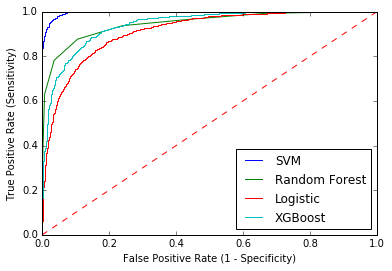

In [116]:
def plot_ROC_curve(models, model_names, X_train, y_train, X_test, y_test):
    print('AUC Score')
    for name, model in zip(model_names, models):
        model.fit(X_train, y_train)
        pred_probs = model.predict_proba(X_test)

        fpr, tpr, thresholds = roc_curve(y_test, pred_probs[:, 1])
        plt.plot(fpr, tpr, label=name);
        plt.legend(loc='best');
        print(name + ': %6.4f' % roc_auc_score(y_test, pred_probs[:, 1]))
    plt.plot(fpr, fpr, 'r--');
    plt.xlabel("False Positive Rate");
    plt.ylabel("True Positive Rate (Sensitivity)");


svc = SVC(probability=True)
rfc = RandomForestClassifier()
logit = LogisticRegression()
gbm = xgb.XGBClassifier()

model_names = ['SVM', 'Random Forest', 'Logistic Regression', 'XGBoost']
models = [svc, rfc, logit, gbm]

plot_ROC_curve(models, model_names, X_train, y_train, X_test, y_test)

## Grid Search best parameters for SVM, RF and XGBoost

In [121]:
from sklearn import linear_model
from sklearn import grid_search
def model_grid_search(model, X_train, X_test, y_train, y_test, params):
    grid_searcher = grid_search.GridSearchCV(model, params)
    grid_searcher.fit(X_train, y_train)
    print('best_param: ', grid_searcher.best_params_)
    best_model = grid_searcher.best_estimator_
    print('best_score: ', best_model.score(X_test,y_test))

In [122]:
svc = SVC()
parameters ={ "C": [1,3,5]}
model_grid_search(svc, X_train, X_test, y_train, y_test, parameters)

best_param:  {'C': 3}
best_score:  0.88201019665


In [125]:
rfc = RandomForestClassifier()

parameters ={ "n_estimators": [30,100],
              "max_depth": [3,4,5]}
model_grid_search(gbm, X_train, X_test, y_train, y_test, parameters)

best_param:  {'max_depth': 5, 'n_estimators': 100}
best_score:  0.892206846322


In [126]:
gbm = xgb.XGBClassifier()

parameters ={ "n_estimators": [100,300,500],
              "learning_rate": [0.03, 0.05, 0.1],
              "max_depth": [3,4,5]}
model_grid_search(gbm, X_train, X_test, y_train, y_test, parameters)

best_param:  {'max_depth': 5, 'n_estimators': 500, 'learning_rate': 0.1}
best_score:  0.965404224326


## final model run with the optimal parameters

In [129]:
svc = SVC(C=3)
rfc = RandomForestClassifier(n_estimators=100)
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.1)

model_names = ['SVM', 'Random Forest', 'XGBoost']
models = [svc, rfc, gbm]
for name, model in zip(model_names, models):
    model.fit(X_train, y_train)

    print(name)
    print('Accuracy: %6.4f' % accuracy_score(model.predict(X_test), y_test))
    print(classification_report(y_test, model.predict(X_test)))

SVM
Accuracy: 0.8820
             precision    recall  f1-score   support

          0       0.81      1.00      0.90      1399
          1       1.00      0.76      0.86      1347

avg / total       0.90      0.88      0.88      2746

Random Forest
Accuracy: 0.9599
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      1399
          1       0.97      0.95      0.96      1347

avg / total       0.96      0.96      0.96      2746

XGBoost
Accuracy: 0.9654
             precision    recall  f1-score   support

          0       0.97      0.96      0.97      1399
          1       0.96      0.97      0.96      1347

avg / total       0.97      0.97      0.97      2746



AUC Score
SVM: 0.9959
Random Forest: 0.9890
XGBoost: 0.9146


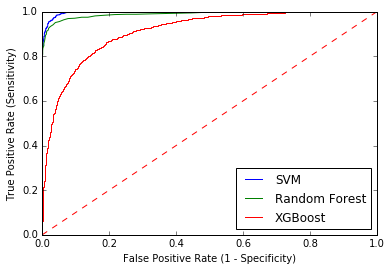

In [139]:
svc = SVC(C=3, probability=True)
rfc = RandomForestClassifier(n_estimators=100)
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.1)

model_names = ['SVM', 'Random Forest', 'XGBoost']
models = [svc, rfc, logit, gbm]

plot_ROC_curve(models, model_names, X_train, y_train, X_test, y_test)

## Pickle final model

In [135]:
joblib.dump(cluster_model_final, 'cluster_model_final.pkl')
y_train = y[training_ids]
rfc.fit(X_train, y_train)
joblib.dump(rfc, 'classification_model_final.pkl')

['classification_model_final.pkl']